## Step1. 검증용 데이터셋 준비

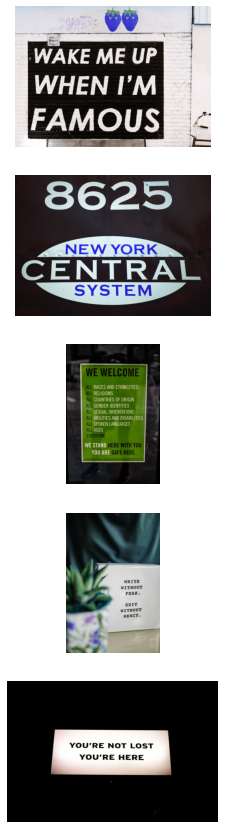

In [87]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont


image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

def url_to_image(url):
    image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
    image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR)
    image = Image.fromarray(image)
    return image

plt.figure(figsize=(10, 15))
for i, url in enumerate(image_urls):
    image = url_to_image(url)
    plt.subplot(len(image_urls), 1, i+1)
    plt.imshow(image)
    plt.axis("off")

## Step2. Google OCR API, keras-ocr, Tesseract로 테스트 진행

### Google OCR API

In [81]:
def get_google_ocr_result(image):
    from google.cloud import vision
    import io
    import os
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

    client = vision.ImageAnnotatorClient()

    # with io.open(image_urls[0], 'rb') as image_file:
    #     content = image_file.read()
    output = io.BytesIO()
    image.save(output, format='JPEG')
    image = vision.Image(content=output.getvalue())

    response = client.text_detection(image=image)
    texts = response.text_annotations
    return texts

In [88]:
def pil_draw_rect_with_label(image, point1, point2, text):
    draw = ImageDraw.Draw(image)
    draw.rectangle((point1, point2), outline=(0, 0, 255), width=3)

    x1, y1 = point1
    imageFont = ImageFont.load_default()
    text_width, text_height = imageFont.getsize(text) 
    draw.rectangle(((x1, y1 - text_height), (x1 + text_width, y1)), fill=(0, 0, 255)) #채워진 사각형
    draw.text((x1, y1 - text_height), text, font=imageFont, fill=(255, 0, 0))
    print(text)
    return image

WAKE ME UP
WHEN I'M
FAMOUS

WAKE
ME
UP
WHEN
I'M
FAMOUS


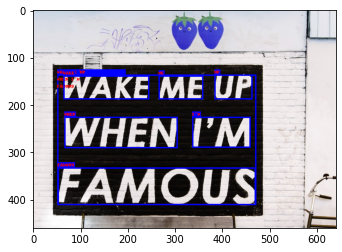

8625
NEW YORK
CENTRAL
SYSTEM

8625
NEW
YORK
CENTRAL
SYSTEM


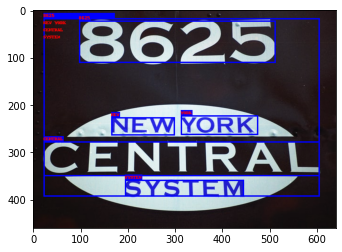

WE WELCOME
ALL RACES AND ETHNICITIES
ALL RELIGIONS
ALL COUNTRIES OF ORIGIN
ALL GENDER IDENTITIES
ALL SEXUAL ORIENTATIONS
ALL ABILITIES AND DISABILITIES
ALL SPOKEN LANGUAGES
ALL AGES
EVERYONE.
WE STAND HERE WITH YOU
YOU ARE SAFE HERE
* Content adapted from the original "We Welcome" sign created by IPRC members Lisa Mangum and Jason Levian

WE
WELCOME
ALL
RACES
AND
ETHNICITIES
ALL
RELIGIONS
ALL
COUNTRIES
OF
ORIGIN
ALL
GENDER
IDENTITIES
ALL
SEXUAL
ORIENTATIONS
ALL
ABILITIES
AND
DISABILITIES
ALL
SPOKEN
LANGUAGES
ALL
AGES
EVERYONE.
WE
STAND
HERE
WITH
YOU
YOU
ARE
SAFE
HERE
*
Content
adapted
from
the
original
"We
Welcome"
sign
created
by
IPRC
members
Lisa
Mangum
and
Jason
Levian


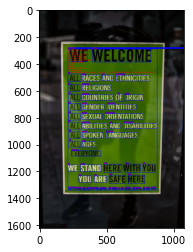

WRITE
WITHOUT
FEAR.
EDIT
WITHOUT
MERCY.
NEECA

WRITE
WITHOUT
FEAR.
EDIT
WITHOUT
MERCY.
NEECA


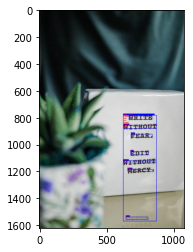

YOU'RE NOT LOST
YOU'RE HERE

YOU'RE
NOT
LOST
YOU'RE
HERE


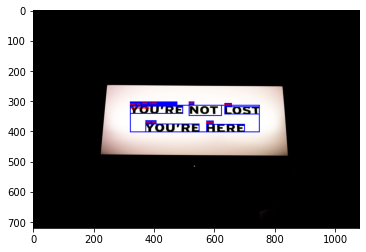

In [89]:
for i, url in enumerate(image_urls):
    image = url_to_image(url)
    results = get_google_ocr_result(image)
    for result in results:
        start = (result.bounding_poly.vertices[0].x, result.bounding_poly.vertices[0].y)
        end = (result.bounding_poly.vertices[2].x, result.bounding_poly.vertices[2].y)
        image = pil_draw_rect_with_label(image, start, end, result.description)
        
    plt.imshow(image)
    plt.show()

### keras-ocr

In [90]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [91]:
images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


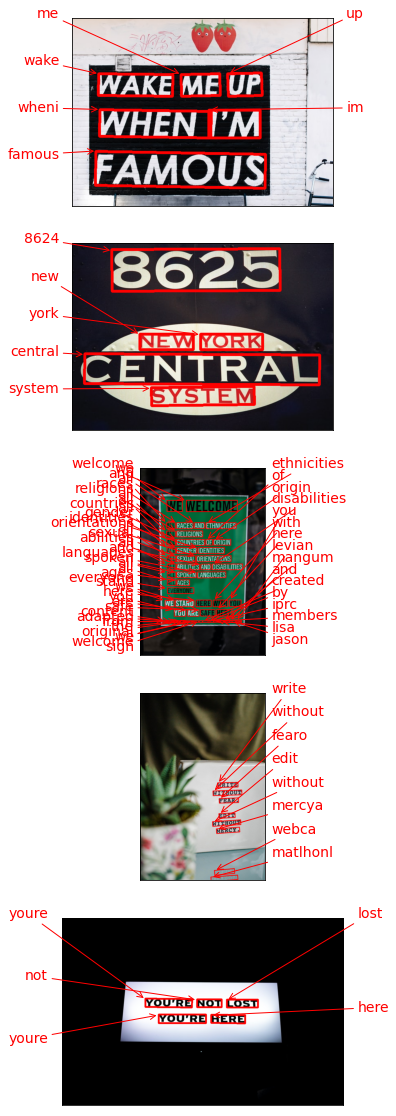

In [92]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### Tesseract

In [100]:
import pytesseract
from pytesseract import Output


for i, url in enumerate(image_urls):
    image = url_to_image(url)
    image = image.convert("L")
    result = pytesseract.image_to_data(image, lang='eng', config=r'--oem 1 --psm 3', output_type=Output.DICT)
#     print(result)
    for i in range(0, len(result['text'])):
        left = result['left'][i]
        top = result['top'][i]
        width = result['width'][i]
        height = result['height'][i]
        text = result['text'][i]
        conf = int(result['conf'][i])
        
        if conf > 0:
            text = "".join([c if ord(c) < 128 else "" for c in text]).strip()
            start = (left, top)
            end = (left+width, top+height)
#             print(left, top, width, height)
            pil_draw_rect_with_label(image, start, end, text)
    plt.imshow(image)
    plt.show()
#     for result in results:
#         start = (result.bounding_poly.vertices[0].x, result.bounding_poly.vertices[0].y)
#         end = (result.bounding_poly.vertices[2].x, result.bounding_poly.vertices[2].y)
#         image = pil_draw_rect_with_label(image, start, end, result.description)
        
#     plt.imshow(image)
#     plt.show()

TypeError: function takes exactly 1 argument (3 given)